In [3]:
import re
from wordcloud import WordCloud
import pandas as pd
from flask import request
from flasgger import Swagger, LazyString, LazyJSONEncoder
from flasgger import swag_from
from flask import Flask, jsonify
import sqlite3
import demoji
import emoji
from unidecode import unidecode
import matplotlib as mpl
import matplotlib.pyplot as plt
from collections import Counter


# Fungsi-fungsi

In [30]:
#fungsi untuk menghilangkan karakter
def clean_karakter(texts):
    tanpa_hex = [re.sub(r'\\x..', ' ', text) for text in texts]
    tanpa_backslash = [re.sub(r'\\', ' ', text) for text in tanpa_hex]
    tanpa_newline = [re.sub(r'\n', ' ', text) for text in tanpa_backslash]
    non_ascii = [re.sub(r'[^\x00-\x7F]+', ' ', text) for text in tanpa_newline]   
    non_url = [re.sub(r'https?://\S+|www\.\S+', ' ', text) for text in non_ascii]
    non_whitespace = [re.sub(r'\s+', ' ', text) for text in non_url]
    only_text = [re.sub(r'[^a-zA-Z0-9\s]', ' ', text) for text in non_whitespace]
    lower_text = [re.sub(r'[A-Z]', lambda x: x.group(0).lower(), text) for text in only_text]
    tanpa_kata_user = [re.sub(r'\buser\b', ' ', text) for text in lower_text]
    tanpa_kata_RT = [re.sub(r'\brt\b', ' ', text) for text in tanpa_kata_user]
    cleaned_text_new = [re.sub(r'\s+', ' ', text).strip() for text in tanpa_kata_RT]
    return cleaned_text_new

In [ ]:
def remove_abusive(text):
    df_abusive = pd.read_csv('asset-challenges/abusive.csv')
    abusive_words = df_abusive['ABUSIVE'].tolist()
    abusive_words_lower = [word.lower() for word in abusive_words]
    for kata in abusive_words_lower:
        text = re.sub(r'\b' + re.escape(kata) + r'\b', '', text, flags=re.IGNORECASE)
    cleaned_text = re.sub(' +', ' ', text).strip()
    
    return cleaned_text

In [ ]:
def replace_kata_alay(text, df_kamusalay):
    words = text.split()
    for i in range(len(words)):
        if words[i] in df_kamusalay['kata_alay'].values:
            new_word = df_kamusalay.loc[df_kamusalay['kata_alay'] == words[i], 'kata_baku'].values[0]
            words[i] = new_word
    return ' '.join(words)

# 1. Neural Network

In [3]:
df_abussive = pd.read_csv('asset-challenges/abusive.csv')
# df_abussive.head()

In [4]:

df_kamusalay = pd.read_csv('asset-challenges/new_kamusalay.csv', header=None, names=['kata_alay', 'kata_baku'],encoding='latin-1')
df_kamusalay['kata_alay'] = df_kamusalay['kata_alay'].str.lower()
df_kamusalay['kata_baku'] = df_kamusalay['kata_baku'].str.lower()
df_kamusalay.head(1)

,kata_alay,kata_baku
0,anakjakartaasikasik,anak jakarta asyik asyik


In [5]:
df_data = pd.read_csv('asset-challenges/data.csv',encoding='utf-8')
df_data.head(1)

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0


In [6]:
df_data.duplicated().sum()

125

--------------------------------------------------------------------------------------------------------------------------------

In [7]:
import pandas as pd
import re

df = pd.read_csv('platinum/train_preprocess.tsv.txt', sep='\t', header=None, names=['text', 'label'], quoting=3)
# df_train = pd.read_csv('/content/train.csv')
# df = pd.concat([df_train, df_preprocessed], ignore_index=True)

# df_test = pd.read_csv('/content/test.csv')
# df = pd.concat([df, df_test], ignore_index=True)

# # df.shape
# def cleansing(text):
#     string = text.lower()
#     string = re.sub(r'[^a-zA-Z0-9]',' ', string)
#     return string
# df['text_clean'] = df.text.apply(cleansing)
df.head()

,text,label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative


In [8]:
def clean_kar(text):
    text = re.sub(r'\\x..', ' ', text)
    text = re.sub(r'\\', ' ', text)
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    text = re.sub(r'[A-Z]', lambda x: x.group(0).lower(), text)
    text = re.sub(r'\buser\b', ' ', text)
    text = re.sub(r'\brt\b', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

    
    
df['text_clean'] = df.text.apply(clean_kar)

In [9]:
df.label.value_counts()

positive    6416
negative    3436
neutral     1148
Name: label, dtype: int64

In [10]:
data_preprocessed = df.text_clean.tolist()
data_preprocessed

['warung ini dimiliki oleh pengusaha pabrik tahu yang sudah puluhan tahun terkenal membuat tahu putih di bandung tahu berkualitas dipadu keahlian memasak dipadu kretivitas jadilah warung yang menyajikan menu utama berbahan tahu ditambah menu umum lain seperti ayam semuanya selera indonesia harga cukup terjangkau jangan lewatkan tahu bletoka nya tidak kalah dengan yang asli dari tegal',
 'mohon ulama lurus dan k212 mmbri hujjah partai apa yang harus diwlh agar suara islam tidak pecah pecah',
 'lokasi strategis di jalan sumatera bandung tempat nya nyaman terutama sofa di lantai 2 paella nya enak sangat pas dimakan dengan minum bir dingin appetiser nya juga enak enak',
 'betapa bahagia nya diri ini saat unboxing paket dan barang nya bagus menetapkan beli lagi',
 'duh jadi mahasiswa jangan sombong dong kasih kartu kuning segala belajar dulu yang baik tidak usahlah ikut ikut politik nanti sudah selesai kuliah nya mau ikut politik juga tidak telat dasar mahasiswa',
 'makanan beragam harga ma

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
count_vect.fit(data_preprocessed)

X = count_vect.transform(data_preprocessed)
print("Feature Extraction finished")

Feature Extraction finished


In [12]:
import pickle

pickle.dump(count_vect, open("platinum/feature.p", "wb"))

In [13]:
from sklearn.model_selection import train_test_split

classes = df.label
classes

0        positive
1         neutral
2        positive
3        positive
4        negative
           ...   
10995    positive
10996    positive
10997     neutral
10998    negative
10999    positive
Name: label, Length: 11000, dtype: object

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, classes, test_size = 0.2)

In [15]:
import nltk
from nltk.corpus import stopwords as stopwords_scratch
nltk.download('stopwords')

list_stopwords = stopwords_scratch.words('indonesian')
list_stopwords_en = stopwords_scratch.words('english')
list_stopwords.extend(list_stopwords_en)
list_stopwords.extend(['ya', 'yg', 'ga', 'yuk', 'dah'])
stopwords = list_stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\akung\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
stopwords[:3]

['ada', 'adalah', 'adanya']

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words=stopwords)
X = vectorizer.fit_transform(df.text.to_list())

C:\Users\akung\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'sekurang', 'setidak', 'tama', 'tidaknya'] not in stop_words.
  warnings.warn(


In [18]:
from sklearn.cluster import KMeans

true_k = 2
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X)

KMeans(max_iter=100, n_clusters=2, n_init=1)

In [19]:
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

for i in range(true_k):
  print("Cluster %d:" % i)
  for ind in order_centroids[i, :10]:
    print(' %s' % terms[ind])
  print()

Cluster 0:
 nya
 orang
 jokowi
 marah
 banget
 indonesia
 indosat
 suka
 pakai
 bandung

Cluster 1:
 nya
 enak
 makanan
 makan
 harga
 menu
 bandung
 restoran
 banget
 nyaman



In [20]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier()
model.fit(X_train, y_train)
print("Training selesai")

Training selesai


In [21]:
pickle.dump(count_vect, open("platinum/model_of_nn/model.p", "wb"))

In [22]:
from sklearn.metrics import classification_report

test = model.predict(X_test)
print("Testing selesai")
print(classification_report(y_test, test))

Testing selesai
              precision    recall  f1-score   support

    negative       0.81      0.81      0.81       721
     neutral       0.81      0.67      0.73       239
    positive       0.88      0.91      0.89      1240

    accuracy                           0.85      2200
   macro avg       0.83      0.80      0.81      2200
weighted avg       0.85      0.85      0.85      2200



In [ ]:
X_train.shape

In [ ]:
X_test.shape

In [37]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from scipy.sparse import vstack

kf = KFold(n_splits=20, random_state=42, shuffle=True)
accuracies = []
y = classes.values  # Mengambil nilai dari kolom target

for iteration, data in enumerate(kf.split(X), start=1):
    train_idx, test_idx = data
    data_train = X[train_idx]
    target_train = y[train_idx]

    data_test = X[test_idx]
    target_test = y[test_idx]

    clf = MLPClassifier()
    clf.fit(data_train, target_train)

    preds = clf.predict(data_test)
    accuracy = accuracy_score(target_test, preds)

    print("Training ke-", iteration)
    print(classification_report(target_test, preds))
    print("========================================")
    accuracies.append(accuracy)

average_accuracy = np.mean(accuracies)
print("Rata-rata accuracy:", average_accuracy)


Training ke- 1
              precision    recall  f1-score   support

    negative       0.73      0.71      0.72       175
     neutral       0.82      0.58      0.68        62
    positive       0.83      0.89      0.86       313

    accuracy                           0.80       550
   macro avg       0.79      0.73      0.75       550
weighted avg       0.80      0.80      0.80       550

Training ke- 2
              precision    recall  f1-score   support

    negative       0.69      0.72      0.70       167
     neutral       0.75      0.44      0.56        54
    positive       0.83      0.86      0.84       329

    accuracy                           0.78       550
   macro avg       0.75      0.67      0.70       550
weighted avg       0.78      0.78      0.77       550

Training ke- 3
              precision    recall  f1-score   support

    negative       0.67      0.77      0.72       163
     neutral       0.76      0.41      0.53        61
    positive       0.85      0

Training ke- 20
              precision    recall  f1-score   support

    negative       0.66      0.71      0.69       164
     neutral       0.73      0.59      0.65        54
    positive       0.87      0.86      0.87       332

    accuracy                           0.79       550
   macro avg       0.75      0.72      0.73       550
weighted avg       0.79      0.79      0.79       550

Rata-rata accuracy: 0.796


In [34]:
with open("platinum/model_of_nn/model_mlp_classifier.pkl", "wb") as file:
    pickle.dump(model, file)


In [55]:
import pickle

# Memuat kembali model dari berkas
with open("platinum/model_of_nn/model_mlp_classifier.pkl", "rb") as file:
    loaded_model = pickle.load(file)
    
    
original_text = '''
meja yang buruk.
'''

# Melakukan preprocessing teks (jika diperlukan)
cleaned_text = clean_kar(original_text)

# Mengubah teks menjadi vektor fitur
text = count_vect.transform([cleaned_text])

# Menggunakan model untuk memprediksi sentimen teks
result = loaded_model.predict(text)[0]

# Mencetak hasil prediksi sentimen
print(f"Sentiment kalimat: ")
print(result)



Sentiment kalimat: 
negative


# 2. LSTM

In [11]:
# df_test = pd.read_csv('platinum/lstm/dataset/test.csv')

df_lstm = pd.read_csv('platinum/train_preprocess.tsv.txt', sep='\t', header=None, names=['text', 'label'], quoting=3)


# df_lstm = df_lstm.append(df_test, ignore_index=True)

In [12]:
df_lstm.head()

,text,label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative


In [13]:
df_lstm.shape

(11000, 2)

In [14]:
df_lstm.label.value_counts()

label
positive    6416
negative    3436
neutral     1148
Name: count, dtype: int64

#### Text Normalization/Cleansing

In [15]:
import re

def cleansing(sent):
    # Mengubah kata menjadi huruf kecil semua dengan menggunakan fungsi lower()
    string = sent.lower()
    # Menghapus emoticon dan tanda baca menggunakan "RegEx" dengan script di bawah
    string = re.sub(r'[^a-zA-Z0-9]', ' ', string)
    return string

In [16]:
df_lstm['text_clean'] = df_lstm.text.apply(cleansing)

In [17]:
df_lstm.head()

,text,label,text_clean
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive,warung ini dimiliki oleh pengusaha pabrik tahu...
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral,mohon ulama lurus dan k212 mmbri hujjah partai...
2,lokasi strategis di jalan sumatera bandung . t...,positive,lokasi strategis di jalan sumatera bandung t...
3,betapa bahagia nya diri ini saat unboxing pake...,positive,betapa bahagia nya diri ini saat unboxing pake...
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative,duh jadi mahasiswa jangan sombong dong kas...


Sortir data dan label berdasarkan sentimenm

In [18]:
neg = df_lstm.loc[df_lstm['label'] == 'negative'].text_clean.tolist()
neu = df_lstm.loc[df_lstm['label'] == 'neutral'].text_clean.tolist()
pos = df_lstm.loc[df_lstm['label'] == 'positive'].text_clean.tolist()

neg_label = df_lstm.loc[df_lstm['label'] == 'negative'].label.tolist()
neu_label = df_lstm.loc[df_lstm['label'] == 'neutral'].label.tolist()
pos_label = df_lstm.loc[df_lstm['label'] == 'positive'].label.tolist()

In [19]:
total_data = pos + neu + neg
labels = pos_label + neu_label + neg_label

print("Pos: %s, Neu: %s, Neg: %s" % (len(pos), len(neu), len(neg)))
print("Total data: %s" % len(total_data))

Pos: 6416, Neu: 1148, Neg: 3436
Total data: 11000


#### Feature Extraction

In [20]:
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import defaultdict

max_features = 100000
tokenizer = Tokenizer(num_words=max_features, split=' ', lower=True)
tokenizer.fit_on_texts(total_data)
with open('platinum/resources_of_lstm/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("tokenizer.pickle has created!")

X = tokenizer.texts_to_sequences(total_data)

vocab_size = len(tokenizer.word_index)
maxlen = max(len(x) for x in X)

X = pad_sequences(X)
with open('platinum/resources_of_lstm/x_pad_sequences.pickle', 'wb') as handle:
    pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("x_pad_sequences.pickle has created!")


tokenizer.pickle has created!
x_pad_sequences.pickle has created!


In [21]:
Y = pd.get_dummies(labels)
Y = Y.values

with open('platinum/resources_of_lstm/y_labels.pickle', 'wb') as handle:
    pickle.dump(Y, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("y_labels.pickle has created!")

y_labels.pickle has created!


#### Prepare train & test datasets/Splitting Dataset

Split dataset menjadi 80% untuk train dan 20% untuk test.

In [24]:
from sklearn.model_selection import train_test_split

file = open("platinum/resources_of_lstm/x_pad_sequences.pickle",'rb')
X = pickle.load(file)
file.close()

file = open("platinum/resources_of_lstm/y_labels.pickle",'rb')
Y = pickle.load(file)
file.close()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

##### Training

In [25]:
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, SimpleRNN, Activation
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Flatten
from tensorflow.keras import backend as K

In [26]:
embed_dim = 100
units = 64

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
model.add(LSTM(units, dropout=0.2))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

adam = optimizers.Adam(lr = 0.001)
model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), verbose=1, callbacks=[es])



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 96, 100)           10000000  
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 10042435 (38.31 MB)
Trainable params: 10042435 (38.31 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None
Epoch 1/10



880/880 [==============================] - 105s 116ms/step - loss: 0.4591 - accuracy: 0.8115 - val_loss: 0.3473 - val_accuracy: 0.8750
Epoch 2/10
880/880 [==============================] - 101s 115ms/step - loss: 0.1936 - accuracy: 0.9268 - val_loss: 0.3646 - val_accuracy: 0.8705
Epoch 2: early stopping


##### Evaluation

 Confussion Matrix, Accuracy, F1, Recall, Precision

In [27]:
from sklearn import metrics

predictions = model.predict(X_test)
y_pred = predictions
matrix_test = metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print("Testing selesai")
print(matrix_test)

69/69 [==============================] - 2s 19ms/step
Testing selesai
              precision    recall  f1-score   support

           0       0.86      0.78      0.82       685
           1       0.78      0.82      0.80       233
           2       0.89      0.93      0.91      1282

    accuracy                           0.87      2200
   macro avg       0.84      0.84      0.84      2200
weighted avg       0.87      0.87      0.87      2200



##### Cross Validation

In [28]:
# Untuk lebih menyakinkan lagi, kita juga bisa melakukan "Cross Validation"
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

kf = KFold(n_splits=5,random_state=42,shuffle=True)

accuracies = []

y = Y

embed_dim = 100
units = 64

for iteration, data in enumerate(kf.split(X), start=1):

    data_train   = X[data[0]]
    target_train = y[data[0]]

    data_test    = X[data[1]]
    target_test  = y[data[1]]


    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
    model.add(LSTM(units, dropout=0.2))
    model.add(Dense(3,activation='softmax'))
    model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])

    adam = optimizers.Adam(lr = 0.001)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=0)
    history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), verbose=0, callbacks=[es])

    predictions = model.predict(X_test)
    y_pred = predictions

    # for the current fold only
    accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))

    print("Training ke-", iteration)
    print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
    print("======================================================")

    accuracies.append(accuracy)

# this is the average accuracy over all folds
average_accuracy = np.mean(accuracies)

print()
print()
print()
print("Rata-rata Accuracy: ", average_accuracy)

69/69 [==============================] - 2s 20ms/step
Training ke- 1
              precision    recall  f1-score   support

           0       0.83      0.84      0.83       685
           1       0.81      0.81      0.81       233
           2       0.91      0.91      0.91      1282

    accuracy                           0.88      2200
   macro avg       0.85      0.85      0.85      2200
weighted avg       0.88      0.88      0.88      2200



69/69 [==============================] - 1s 10ms/step
Training ke- 2
              precision    recall  f1-score   support

           0       0.82      0.84      0.83       685
           1       0.84      0.80      0.82       233
           2       0.92      0.91      0.91      1282

    accuracy                           0.88      2200
   macro avg       0.86      0.85      0.85      2200
weighted avg       0.88      0.88      0.88      2200



69/69 [==============================] - 1s 8ms/step
Training ke- 3
              precision    recall  f1-score   support

           0       0.84      0.80      0.82       685
           1       0.81      0.80      0.81       233
           2       0.90      0.92      0.91      1282

    accuracy                           0.87      2200
   macro avg       0.85      0.84      0.85      2200
weighted avg       0.87      0.87      0.87      2200



69/69 [==============================] - 1s 9ms/step
Training ke- 4
              precision    recall  f1-score   support

           0       0.84      0.78      0.81       685
           1       0.78      0.78      0.78       233
           2       0.90      0.93      0.91      1282

    accuracy                           0.87      2200
   macro avg       0.84      0.83      0.83      2200
weighted avg       0.87      0.87      0.87      2200



69/69 [==============================] - 1s 9ms/step
Training ke- 5
              precision    recall  f1-score   support

           0       0.83      0.81      0.82       685
           1       0.78      0.80      0.79       233
           2       0.90      0.91      0.91      1282

    accuracy                           0.87      2200
   macro avg       0.84      0.84      0.84      2200
weighted avg       0.87      0.87      0.87      2200




Rata-rata Accuracy:  0.8725454545454546


##### Visualisation

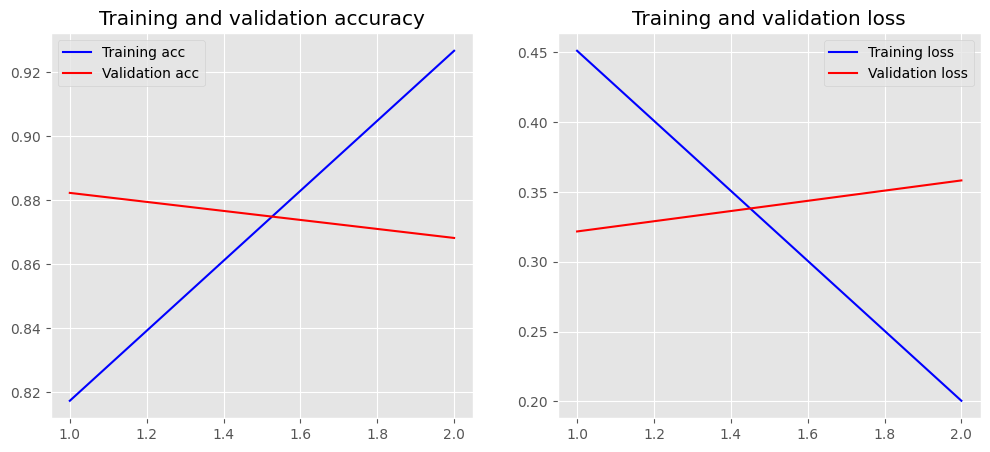

In [35]:
# history.history
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

%matplotlib inline
plot_history(history)

In [36]:
model.save('platinum/model_of_lstm/model.h5')
print("Model has created!")

C:\Users\akung\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model has created!


##### Predict

In [37]:
import re
from keras.models import load_model
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import defaultdict


input_text = """
kamu terlihat buruk.
"""

def cleansing(sent):
    # Mengubah kata menjadi huruf kecil semua dengan menggunakan fungsi lower()
    string = sent.lower()
    # Menghapus emoticon dan tanda baca menggunakan "RegEx" dengan script di bawah
    string = re.sub(r'[^a-zA-Z0-9]', ' ', string)
    return string

sentiment = ['negative', 'neutral', 'positive']

text = [cleansing(input_text)]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('platinum/model_of_lstm/model.h5')
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])

print("Text: ",text[0])
print("Sentiment: ",sentiment[polarity])

1/1 [==============================] - 0s 326ms/step
Text:   kamu terlihat buruk  
Sentiment:  positive


In [7]:
pip list

Package                       Version
----------------------------- ------------
absl-py                       2.1.0
aiofiles                      23.2.1
altair                        5.1.2
anaconda-anon-usage           0.4.3
anaconda-client               1.12.3
anaconda-cloud-auth           0.1.4
anaconda-navigator            2.5.2
annotated-types               0.6.0
anyio                         3.7.1
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
asttokens                     2.0.5
astunparse                    1.6.3
async-lru                     2.0.4
attrs                         23.1.0
Babel                         2.11.0
backcall                      0.2.0
backports.functools-lru-cache 1.6.4
backports.tempfile            1.0
backports.weakref             1.0.post1
beautifulsoup4                4.12.2
bleach                        4.1.0
blinker                       1.7.0
boltons                       23.0.0
Brotli                        1.0.9
bs4      

In [27]:
import re
from flask import Flask, jsonify, request
from flasgger import Swagger, LazyString, LazyJSONEncoder, swag_from

app = Flask(__name__)

app.json_encoder = LazyJSONEncoder
swagger_template = {
    'info': {
        'title': LazyString(lambda: 'API Documentation for Deep Learning'),
        'version': LazyString(lambda: '1.0.0'),
        'description': LazyString(lambda: 'Dokumentasi API untuk Deep Learning'),
    },
    'host': LazyString(lambda: request.host)
}
swagger_config = {
    "headers": [],
    "specs": [
        {
            "endpoint": 'api',
            "route": '/api.json',
        }
    ],
    "static_url_path": "/flasgger_static",
    "swagger_ui": True,
    "specs_route": "/api/"
}

swagger = Swagger(app, template=swagger_template, config=swagger_config)

@app.errorhandler(400)
def bad_request(error):
    return jsonify({'error': 'Bad request'}), 400

@app.errorhandler(404)
def not_found(error):
    return jsonify({'error': 'Not found'}), 404

@app.errorhandler(500)
def internal_server_error(error):
    return jsonify({'error': 'Internal server error'}), 500

@swag_from("C://Users/akung/api/text_processing.yml", methods=['POST'])
@app.route("/text_processing", methods=['POST'])
def text_processing():
    try:
        text = request.form.get('text')
        if not text:
            raise ValueError("Text is empty")

        processed_text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
        json_response = {
            'status_code': 200,
            'description': "teks di proses",
            'data': processed_text,
        }
        return jsonify(json_response)
    except Exception as e:
        return jsonify({'error': str(e)}), 400

if __name__ == '__main__':
    app.run()


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
INFO:werkzeug:Press CTRL+C to quit
127.0.0.1 - - [29/Feb/2024 16:55:29] "GET /api/ HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [29/Feb/2024 16:55:29] "GET /api/ HTTP/1.1" 200 -
127.0.0.1 - - [29/Feb/2024 16:55:29] "GET /flasgger_static/swagger-ui-bundle.js HTTP/1.1" 304 -
INFO:werkzeug:127.0.0.1 - - [29/Feb/2024 16:55:29] "GET /flasgger_static/swagger-ui-bundle.js HTTP/1.1" 304 -
127.0.0.1 - - [29/Feb/2024 16:55:29] "GET /flasgger_static/swagger-ui.css HTTP/1.1" 304 -
INFO:werkzeug:127.0.0.1 - - [29/Feb/2024 16:55:29] "GET /flasgger_static/swagger-ui.css HTTP/1.1" 304 -
127.0.0.1 - - [29/Feb/2024 16:55:29] "GET /flasgger_static/swagger-ui-standalone-preset.js HTTP/1.1" 304 -
INFO:werkzeug:127.0.0.1 - - [29/Feb/2024 16:55:29] "GET /flasgger_static/swagger-ui-standa

# MEMBUAT API

In [38]:
def clean_kar(text):
    text = re.sub(r'\\x..', ' ', text)
    text = re.sub(r'\\', ' ', text)
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    text = re.sub(r'[A-Z]', lambda x: x.group(0).lower(), text)
    text = re.sub(r'\buser\b', ' ', text)
    text = re.sub(r'\brt\b', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [39]:
from tensorflow.keras.preprocessing.text import Tokenizer
# Definisikan parameter untuk feature extraction
max_features = 100000
tokenizer = Tokenizer (num_words=max_features, split = ' ', lower = True)

# Definisikan label untuk sentiment
sentiment = ['negative', 'neutral','positive']

In [40]:
file = open('platinum/resources_of_lstm/x_pad_sequences.pickle', 'rb')
feature_file_from_lstm = pickle.load(file)
file.close()

In [41]:
model_file_from_lstm = load_model ('platinum/model_of_lstm/model.h5')

In [42]:
import pickle

# Memuat kembali model dari berkas
with open("platinum/model_of_nn/model_mlp_classifier.pkl", "rb") as file:
    loaded_model = pickle.load(file)

C:\Users\akung\anaconda3\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelBinarizer from version 1.0.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\akung\anaconda3\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MLPClassifier from version 1.0.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [43]:
import pickle

# Buka file untuk dibaca dalam mode biner ("rb")
with open("platinum/feature.p", "rb") as file:
    # Mengembalikan objek yang disimpan menggunakan pickle
    count_vect = pickle.load(file)

C:\Users\akung\anaconda3\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator CountVectorizer from version 1.0.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [56]:
app = Flask(__name__)

app.json_encoder = LazyJSONEncoder
swagger_template = dict(
info = {
    'title': LazyString(lambda: 'API Documentation for Deep Learning'),
    'version': LazyString(lambda: '1.0.0'),
    'description': LazyString(lambda: 'Dokumentasi API untuk Deep Learning'),
    },
    host = LazyString(lambda: request.host)
)

swagger_config = {
    "headers": [],
    "specs": [
        {
            "endpoint": 'api',
            "route": '/api.json',
        }
    ],
    "static_url_path": "/flasgger_static",
    "swagger_ui": True,
    "specs_route": "/api/"
}


swagger = Swagger(app, template=swagger_template,             
                  config=swagger_config)






# input kalimat
@swag_from("api/neural_network.yml", methods=['POST'])
@app.route('/neural-network', methods=['POST'])
def text_processing_nn():

    original_text = request.form.get('text')

    cleaned_text = re.sub(r'[^a-zA-Z0-9\s]', ' ', original_text)
    cleaned_text = re.sub(' +', ' ', cleaned_text).strip()
    
#     cleaned_text = replace_kata_alay(cleaned_text, df_kamusalay)
#     cleaned_text = remove_abusive(cleaned_text)
#     insert_data(text, cleaned_text)

    # Mengubah teks menjadi vektor fitur
    text = count_vect.transform([cleaned_text])

    # Menggunakan model untuk memprediksi sentimen teks
    result = loaded_model.predict(text)[0]

    
    json_response = {
        'status_code': 200,
        'description': "Hasil Sentimen analisis menggunakan Neural Network",
        'text': cleaned_text,
        'sentiment': result
    }

    response_data = jsonify(json_response)
    return response_data


@swag_from("api/lstm.yml", methods=['POST'])
@app.route('/lstm', methods=['POST'])
def text_processing_lstm():

    original_text = request.form.get('text')

    cleaned_text = re.sub(r'[^a-zA-Z0-9\s]', ' ', original_text)
    cleaned_text = re.sub(' +', ' ', cleaned_text).strip()
    
#     cleaned_text = replace_kata_alay(cleaned_text, df_kamusalay)
#     cleaned_text = remove_abusive(cleaned_text)
#     insert_data(text, cleaned_text)

    feature = tokenizer.texts_to_sequences(text)
    feature = pad_sequences(feature, maxlen=feature_file_from_lstm.shape[1])
    
    prediction = model_file_from_lstm.predict(feature)
    get_sentiment = sentiment[np.argmax(prediction[0])]

    
    json_response = {
        'status_code': 200,
        'description': "Hasil Sentimen analisis menggunakan LSTM",
        'data':{
            'text': original_text,
            'sentiment': get_sentiment
        }
    }

    response_data = jsonify(json_response)
    return response_data





# #input file
# @swag_from("C://Users/akung/api/neural_networkfile.yml", methods=['POST'])
# @app.route('/neural_networkfile', methods=['POST'])
# def file_nn():

#     file = request.files.getlist('file')[0]
#     df_file = pd.read_csv(file,encoding='utf-8')
#     df_file = df_file.drop_duplicates()
#     alay_text = clean_karakter(df_file)

    
#     # cleaned_text_new  = [replace_kata_alay(text, df_kamusalay) for text in alay_text]
    
#     # for i in range(len(cleaned_text_new)):
#     #     cleaned_text_new[i] = remove_abusive(cleaned_text_new[i])
    
#     for text in alay_text.iloc[:,0]:
#         feature = tokenizer.texts_to_sequences(text)
#         feature = pad_sequences(feature, maxlen=feature_file_from_lstm.shape[1])
        
#         prediction = model_file_from_lstm.predict(feature)
#         get_sentiment = sentiment[np.argmax(prediction[0])]
    
#         sentiment_result.append({
#             'text': original_text,
#             'sentiment': get_sentiment


#         })
    

#     json_response = {
#                 'status_code': 200,
#                 'description': "Hasil Sentimen analisis menggunakan LSTM",
#                 'data':sentiment_result
#             }
        
#     response_data = jsonify(json_response)
#     return response_data

if __name__ == '__main__':
   app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [29/Feb/2024 02:49:03] "GET / HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [29/Feb/2024 02:49:07] "GET /api/ HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [29/Feb/2024 02:49:07] "GET /flasgger_static/swagger-ui.css HTTP/1.1" 304 -
INFO:werkzeug:127.0.0.1 - - [29/Feb/2024 02:49:07] "GET /flasgger_static/swagger-ui-bundle.js HTTP/1.1" 304 -
INFO:werkzeug:127.0.0.1 - - [29/Feb/2024 02:49:07] "GET /flasgger_static/swagger-ui-standalone-preset.js HTTP/1.1" 304 -
INFO:werkzeug:127.0.0.1 - - [29/Feb/2024 02:49:07] "GET /flasgger_static/lib/jquery.min.js HTTP/1.1" 304 -
ERROR:root:jsonify failure; defaulting to json.dumps
Traceback (most recent call last):
  File "C:\Users\akung\anaconda3\lib\site-packages\flasgger\utils.py", line 581, in load_from_file
    enc = detec

In [51]:
pip install flasgger


Note: you may need to restart the kernel to use updated packages.


----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------